# ECE 5424 Notebook Display

## Authored by Jason Cusati
## Base Code by John Smutny

In [1]:
'''
File:   main.py
Author: John Smutny
Course: ECE-5424: Advanced Machine Learning
Date:   11/19/2022
Description:
    Run data analysis of NBA Positions to visually and metrically determine
    if the NBA is becoming more position-homogenious over time, by decade.

    If desired, this program will also generate the csv file necessary to run
    the modeling if it is necessary.

    Original dataset provided by Omri Goldstein.
    https://www.kaggle.com/datasets/drgilermo/nba-players-stats?select=Seasons_Stats.csv

Input:
    1) Season_Stats.csv - Dataset from Basketball-Reference.com's
    'Total' and 'Advanced' data.
    2) Players.csv - Dataset from Kaggle (same location as INPUT 1)) that
    contains the heights and weights of all players in INPUT 1.

Output:
    Various. See each model .py file.
'''


import dataPreparation as dp
import hierarchyClustering as hc
from som import som
import pandas as pd
import pca
import kMeans as kM


In [2]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import collections



Cophenetic Correlation Coefficient: 0.63770


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 563.069
SilhouetteCoefficient_Score = -0.018
Davies-Bouldin Index = 4.712
** Model1 (Divisive Clustering): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE
explained variance ratio by Components: 66.10%
	Component (0-100%): [30.87806912 16.62680112  8.58952239  5.77529253  4.23043559]


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.60724


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 703.242
SilhouetteCoefficient_Score = 0.106
Davies-Bouldin Index = 2.481
** Model1 (Divisive Clustering): COMPLETE

---- Start SOM Clustering model ----
Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\som.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model SOM Position Extraction: COMPLETE
Calinski_Harabasz_Score = 810.269
SilhouetteCoefficient_Score = 0.045
Davies-Bouldin Index = 2.201
** Model2 (SOM Clustering): COMPLETE

     ID    Year                Player  height  weight   Age Pos   Tm     G  \
0  3069  1971.0       Zaid Abdul-Aziz   206.0   106.0  24.0   C  SEA  61.0   
1  3070  1971.0  Kareem Abdul-Jabbar*   218.0   102.0  23.0   C  MIL  82.0   
2  3071  1971.0             Don Adams   198.0    95.0  23.0  SF  SDR  82.0   
3  3072  1971.0          Rick Adelman   185.0    79.0  24.0  PG  POR  81.0   
4  3073  1971.0          Lucius Allen   188.0    79.0  23.0  PG  MIL  61.0   

    GS  ...   BLK  TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  Pos_SF  Pos_SG  \
0 -1.0  ...  17.0 -1.0  118.0   665.0      1       0       0       0       0   
1 -1.0  ...  17.0 -1.0  264.0  2596.0      1       0       0       0       0   
2 -1.0  ...  17.0 -1.0  344.0   937.0      0       0       0       1       0   
3 -1.0  ...  17.0 -1.0  214.0  

C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model kMeans Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1010.728
SilhouetteCoefficient_Score = 0.109
Davies-Bouldin Index = 1.614
** Model3 (SOM KMeans): COMPLETE

explained variance ratio by Components: 71.64%
	Component (0-100%): [33.72152294 17.01990434  7.9564635   5.33941792  4.42808037  3.17309693]


C:\Code\Git\vt_AdvML\paper\src\pca.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model PCA Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1005.136
SilhouetteCoefficient_Score = 0.104
Davies-Bouldin Index = 2.357
** Model4 (PCA): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.62128


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 960.864
SilhouetteCoefficient_Score = -0.016
Davies-Bouldin Index = 3.406
** Model1 (Divisive Clustering): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE
explained variance ratio by Components: 69.99%
	Component (0-100%): [32.73774989 19.54410939  7.31316803  5.97384925  4.41883092]


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.64508


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 982.263
SilhouetteCoefficient_Score = 0.002
Davies-Bouldin Index = 3.558
** Model1 (Divisive Clustering): COMPLETE

---- Start SOM Clustering model ----
Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\som.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model SOM Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1325.563
SilhouetteCoefficient_Score = 0.054
Davies-Bouldin Index = 2.625
** Model2 (SOM Clustering): COMPLETE

        ID    Year                Player  height  weight   Age Pos   Tm     G  \
2197  6085  1981.0  Kareem Abdul-Jabbar*   218.0   102.0  33.0   C  LAL  80.0   
2198  6086  1981.0         Tom Abernethy   201.0    99.0  26.0  SF  TOT  78.0   
2199  6089  1981.0           Alvan Adams   206.0    95.0  26.0   C  PHO  75.0   
2200  6090  1981.0        Darrell Allums   206.0    99.0  22.0  PF  DAL  22.0   
2201  6091  1981.0       Tiny Archibald*   185.0    68.0  32.0  PG  BOS  80.0   

        GS  ...    BLK    TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  Pos_SF  \
2197  15.0  ...  228.0  249.0  244.0  2095.0      1       0       0       0   
2198  15.0  ...    6.0   16.0   68.0   126.0      0       0       0       1   
2199  15.0  ...   69.0  226.0  226.0  1115.0      1       0       0       0   
2200  15.0  ... 

C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model kMeans Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1690.184
SilhouetteCoefficient_Score = 0.071
Davies-Bouldin Index = 3.196
** Model3 (SOM KMeans): COMPLETE

explained variance ratio by Components: 71.23%
	Component (0-100%): [35.52166606 19.02729549  6.66582008  5.64645414  4.37007227]


C:\Code\Git\vt_AdvML\paper\src\pca.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model PCA Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1723.996
SilhouetteCoefficient_Score = 0.072
Davies-Bouldin Index = 2.754
** Model4 (PCA): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.60960


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1049.438
SilhouetteCoefficient_Score = -0.017
Davies-Bouldin Index = 4.117
** Model1 (Divisive Clustering): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE
explained variance ratio by Components: 69.30%
	Component (0-100%): [32.39478665 19.28108352  7.86460825  5.27510601  4.48782572]


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.64647


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1391.912
SilhouetteCoefficient_Score = 0.011
Davies-Bouldin Index = 3.352
** Model1 (Divisive Clustering): COMPLETE

---- Start SOM Clustering model ----
Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\som.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model SOM Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1988.33
SilhouetteCoefficient_Score = 0.061
Davies-Bouldin Index = 2.938
** Model2 (SOM Clustering): COMPLETE

         ID    Year              Player  height  weight   Age Pos   Tm     G  \
5041  10007  1991.0      Alaa Abdelnaby   208.0   108.0  22.0  PF  POR  43.0   
5042  10008  1991.0  Mahmoud Abdul-Rauf   188.0    83.0  21.0  PG  DEN  67.0   
5043  10009  1991.0          Mark Acres   211.0    99.0  28.0   C  ORL  68.0   
5044  10010  1991.0       Michael Adams   178.0    73.0  28.0  PG  DEN  66.0   
5045  10011  1991.0        Mark Aguirre   198.0   105.0  31.0  SF  DET  78.0   

        GS  ...   BLK    TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  Pos_SF  \
5041   0.0  ...  12.0   22.0   39.0   135.0      0       1       0       0   
5042  19.0  ...   4.0  110.0  149.0   942.0      0       0       1       0   
5043   0.0  ...  25.0   42.0  218.0   285.0      1       0       0       0   
5044  66.0  ...   6.0  240.

C:\Code\Git\vt_AdvML\paper\src\kMeans.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))
C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = ne

** Model kMeans Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1859.156
SilhouetteCoefficient_Score = 0.052
Davies-Bouldin Index = 2.124
** Model3 (SOM KMeans): COMPLETE

explained variance ratio by Components: 70.91%
	Component (0-100%): [34.90459248 19.79139451  7.43525512  4.88682342  3.89003425]


C:\Code\Git\vt_AdvML\paper\src\pca.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model PCA Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1886.73
SilhouetteCoefficient_Score = 0.053
Davies-Bouldin Index = 2.195
** Model4 (PCA): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.60531


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1127.199
SilhouetteCoefficient_Score = -0.006
Davies-Bouldin Index = 3.702
** Model1 (Divisive Clustering): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE
explained variance ratio by Components: 70.13%
	Component (0-100%): [32.43479708 20.1359842   7.72925564  5.13845343  4.6918096 ]


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.65432


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1178.242
SilhouetteCoefficient_Score = -0.027
Davies-Bouldin Index = 2.787
** Model1 (Divisive Clustering): COMPLETE

---- Start SOM Clustering model ----
Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\som.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model SOM Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1462.184
SilhouetteCoefficient_Score = 0.009
Davies-Bouldin Index = 2.677
** Model2 (SOM Clustering): COMPLETE

         ID    Year               Player  height  weight   Age Pos   Tm     G  \
8480  14967  2001.0   Mahmoud Abdul-Rauf   188.0    83.0  31.0  PG  VAN  41.0   
8481  14968  2001.0    Tariq Abdul-Wahad   198.0   101.0  26.0  SG  DEN  29.0   
8482  14969  2001.0  Shareef Abdur-Rahim   206.0   102.0  24.0  SF  VAN  81.0   
8483  14970  2001.0       Cory Alexander   185.0    83.0  27.0  PG  ORL  26.0   
8484  14971  2001.0   Courtney Alexander   185.0    83.0  23.0  PG  TOT  82.0   

        GS  ...   BLK    TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  Pos_SF  \
8480   0.0  ...   1.0   26.0   50.0   266.0      0       0       1       0   
8481  12.0  ...  13.0   34.0   54.0   111.0      0       0       0       0   
8482  81.0  ...  77.0  231.0  238.0  1663.0      0       0       0       1   
8483   0.0  ...   0.

C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model kMeans Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1986.404
SilhouetteCoefficient_Score = 0.057
Davies-Bouldin Index = 3.434
** Model3 (SOM KMeans): COMPLETE

explained variance ratio by Components: 70.51%
	Component (0-100%): [35.18867026 19.46071258  7.16501229  4.67984552  4.01402823]


C:\Code\Git\vt_AdvML\paper\src\pca.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model PCA Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1957.655
SilhouetteCoefficient_Score = 0.059
Davies-Bouldin Index = 2.496
** Model4 (PCA): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.60288


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 799.791
SilhouetteCoefficient_Score = 0.014
Davies-Bouldin Index = 3.725
** Model1 (Divisive Clustering): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE
explained variance ratio by Components: 70.18%
	Component (0-100%): [30.82005217 20.11680417  8.27094794  5.98994036  4.97749625]


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.60226


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1204.914
SilhouetteCoefficient_Score = 0.051
Davies-Bouldin Index = 2.305
** Model1 (Divisive Clustering): COMPLETE

---- Start SOM Clustering model ----
Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\som.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model SOM Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1169.623
SilhouetteCoefficient_Score = 0.035
Davies-Bouldin Index = 3.119
** Model2 (SOM Clustering): COMPLETE

          ID    Year             Player  height  weight   Age Pos   Tm     G  \
12236  20502  2011.0      Arron Afflalo   196.0    95.0  25.0  SG  DEN  69.0   
12237  20504  2011.0      Alexis Ajinca   218.0   112.0  22.0   C  TOT  68.0   
12238  20509  2011.0  LaMarcus Aldridge   211.0   117.0  25.0  PF  POR  81.0   
12239  20511  2011.0          Ray Allen   203.0    99.0  35.0  SG  BOS  80.0   
12240  20512  2011.0         Tony Allen   193.0    96.0  29.0  SG  MEM  72.0   

         GS  ...   BLK    TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  Pos_SF  \
12236  69.0  ...  31.0   71.0  153.0   867.0      0       0       0       0   
12237   4.0  ...  38.0   36.0  146.0   286.0      1       0       0       0   
12238  81.0  ...  94.0  153.0  220.0  1769.0      0       1       0       0   
12239  80.0  ...  16.0

C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model kMeans Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1541.423
SilhouetteCoefficient_Score = 0.092
Davies-Bouldin Index = 2.511
** Model3 (SOM KMeans): COMPLETE

explained variance ratio by Components: 70.86%
	Component (0-100%): [33.96759878 19.63542435  7.60059366  5.59199857  4.06528687]


C:\Code\Git\vt_AdvML\paper\src\pca.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model PCA Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1514.492
SilhouetteCoefficient_Score = 0.101
Davies-Bouldin Index = 2.058
** Model4 (PCA): COMPLETE



,Years,CHS,SC,DBI
0,1971-1980,563.069,-0.018,4.712
1,1981-1990,960.864,-0.016,3.406
2,1991-2000,1049.438,-0.017,4.117
3,2001-2010,1127.199,-0.006,3.702
4,2011-2020,799.791,0.014,3.725


,Years,CHS,SC,DBI
0,1971-1980,703.242,0.106,2.481
1,1981-1990,982.263,0.002,3.558
2,1991-2000,1391.912,0.011,3.352
3,2001-2010,1178.242,-0.027,2.787
4,2011-2020,1204.914,0.051,2.305


,Years,CHS,SC,DBI
0,1971-1980,810.269,0.045,2.201
1,1981-1990,1325.563,0.054,2.625
2,1991-2000,1988.330,0.061,2.938
3,2001-2010,1462.184,0.009,2.677
4,2011-2020,1169.623,0.035,3.119


,Years,CHS,SC,DBI
0,1971-1980,1010.728,0.109,1.614
1,1981-1990,1690.184,0.071,3.196
2,1991-2000,1859.156,0.052,2.124
3,2001-2010,1986.404,0.057,3.434
4,2011-2020,1541.423,0.092,2.511


,Years,CHS,SC,DBI
0,1971-1980,1005.136,0.104,2.357
1,1981-1990,1723.996,0.072,2.754
2,1991-2000,1886.730,0.053,2.195
3,2001-2010,1957.655,0.059,2.496
4,2011-2020,1514.492,0.101,2.058


'\nNOTES for later\n1. When outputting metrics for clusters for DEBUG (1971-1990) vs ALL (\n1971-2020), the metrics for overlapping years was not consistent.\n\n'

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

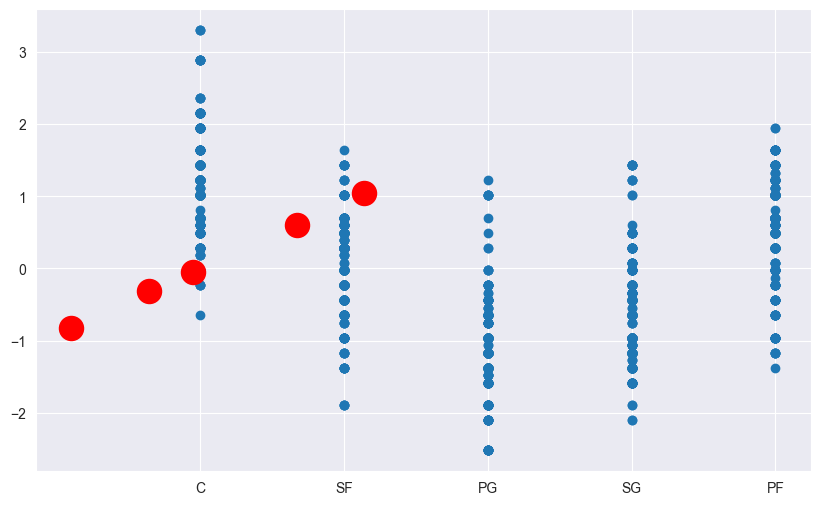

<Figure size 640x480 with 0 Axes>

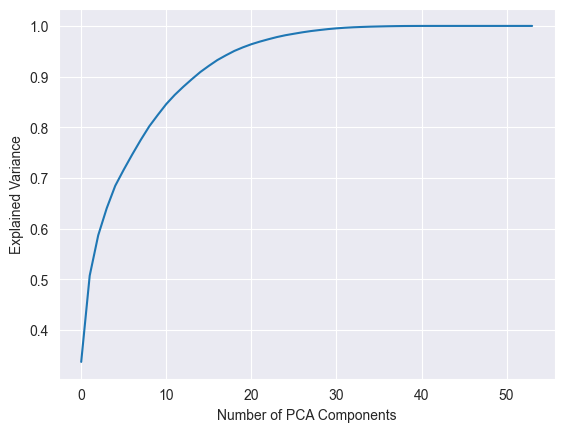

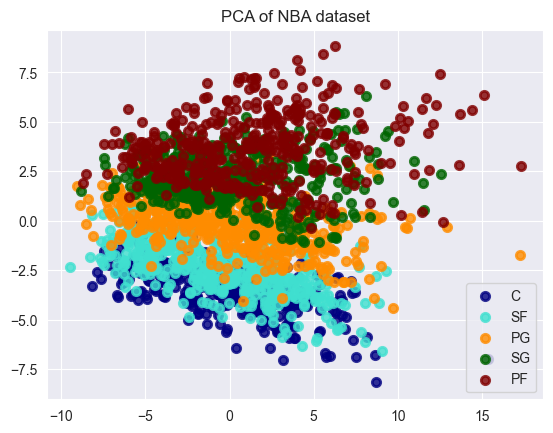

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

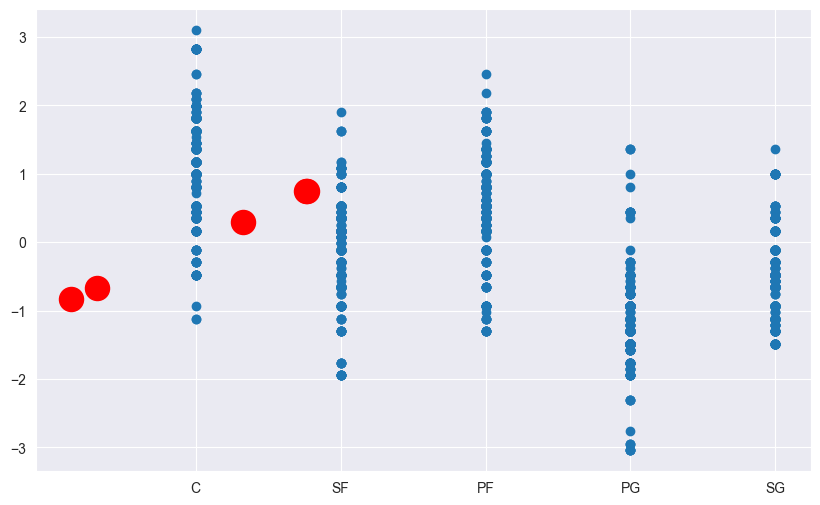

<Figure size 640x480 with 0 Axes>

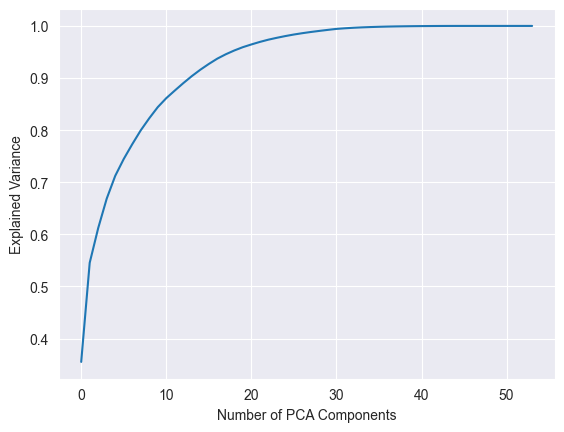

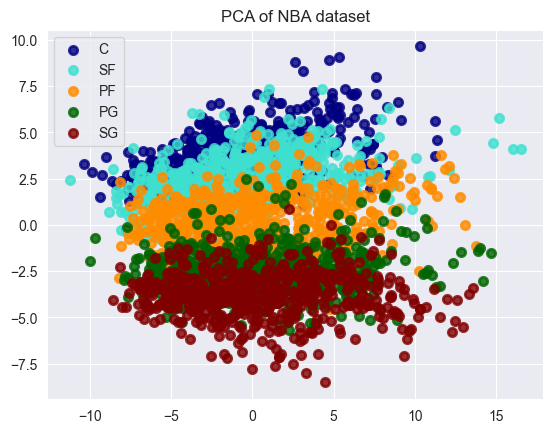

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

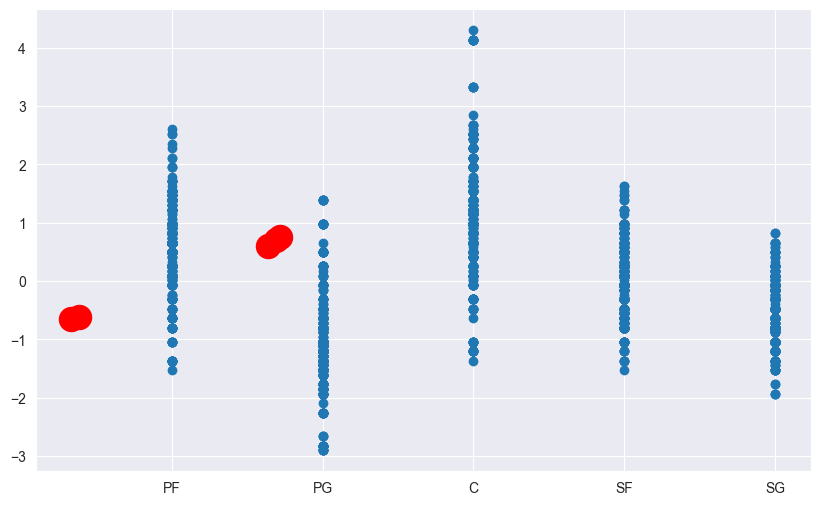

<Figure size 640x480 with 0 Axes>

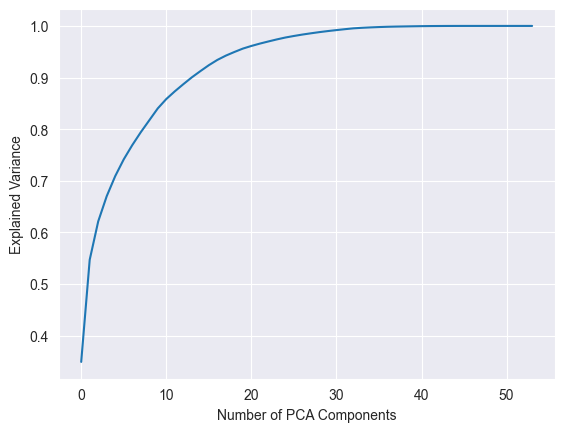

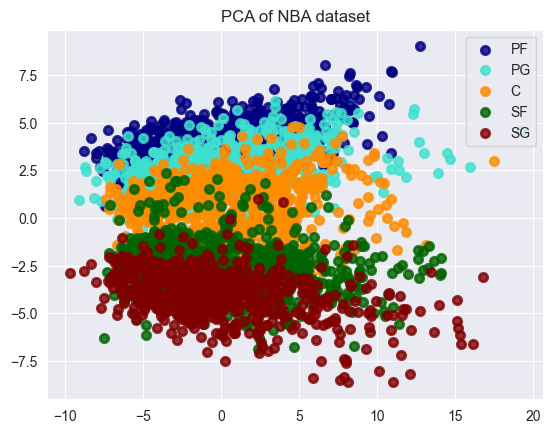

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

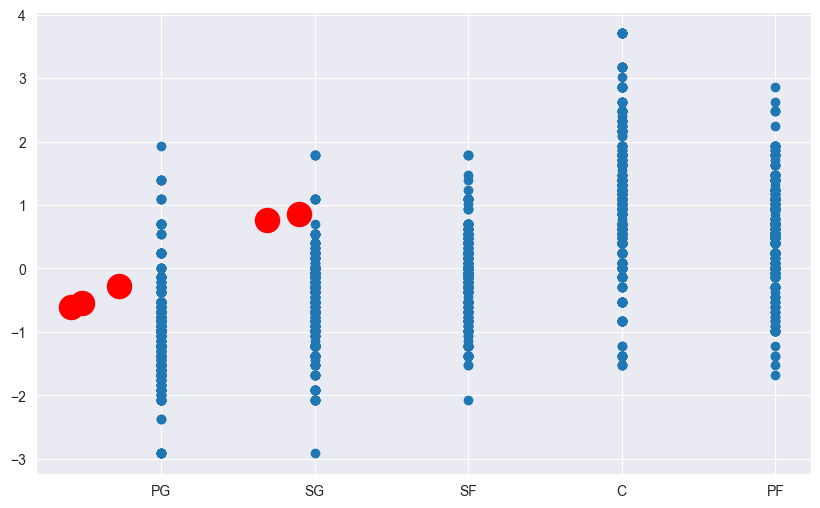

<Figure size 640x480 with 0 Axes>

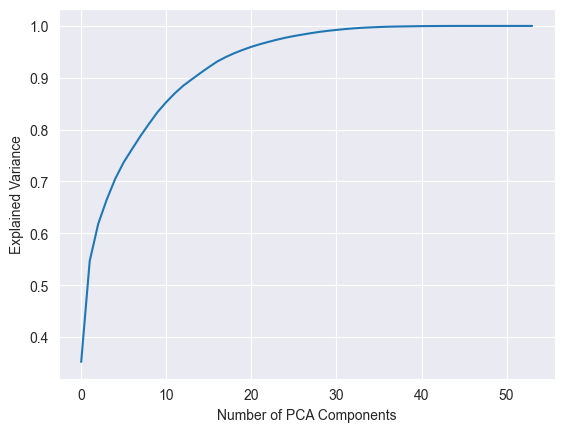

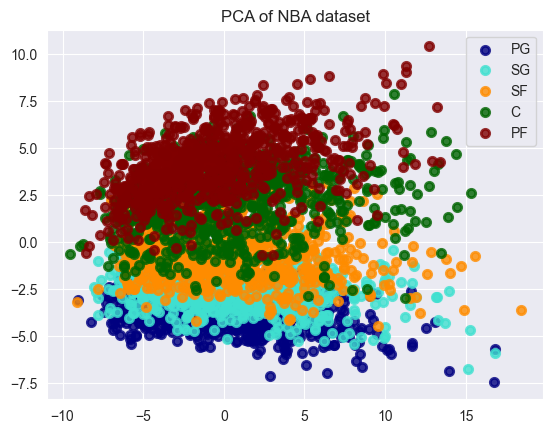

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

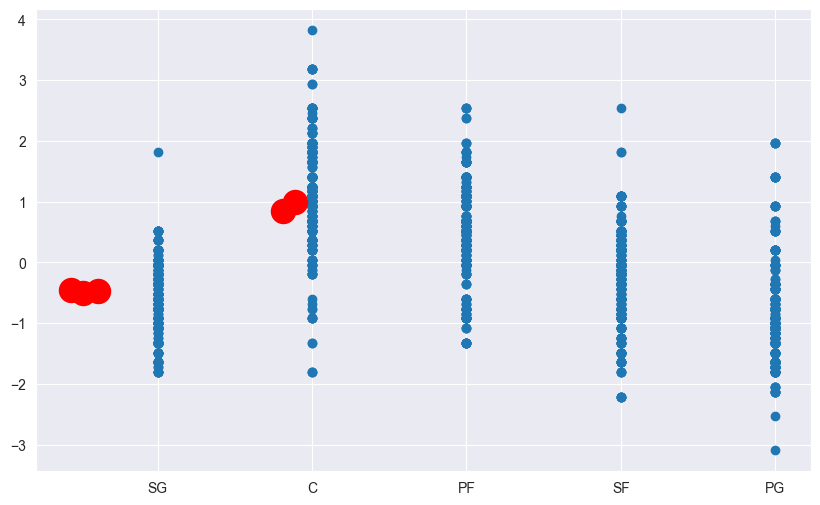

<Figure size 640x480 with 0 Axes>

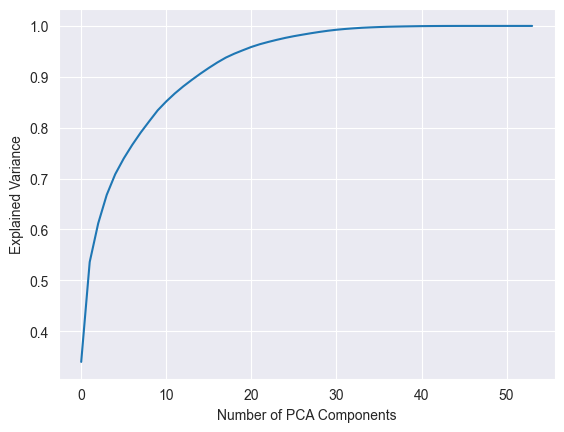

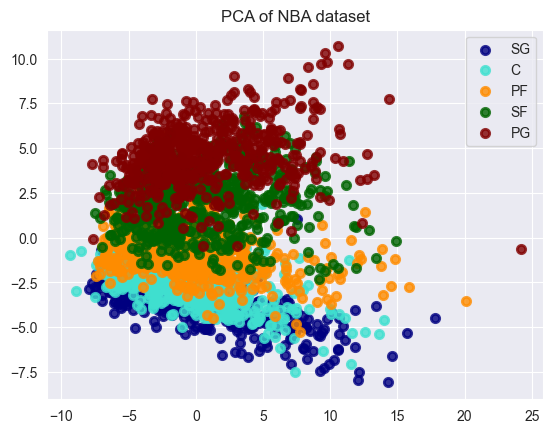

<Figure size 640x480 with 0 Axes>

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.63770


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 563.069
SilhouetteCoefficient_Score = -0.018
Davies-Bouldin Index = 4.712
** Model1 (Divisive Clustering): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE
explained variance ratio by Components: 66.10%
	Component (0-100%): [30.87806912 16.62680112  8.58952239  5.77529253  4.23043557]


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.60724


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 703.242
SilhouetteCoefficient_Score = 0.106
Davies-Bouldin Index = 2.481
** Model1 (Divisive Clustering): COMPLETE

---- Start SOM Clustering model ----
Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\som.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model SOM Position Extraction: COMPLETE
Calinski_Harabasz_Score = 810.269
SilhouetteCoefficient_Score = 0.045
Davies-Bouldin Index = 2.201
** Model2 (SOM Clustering): COMPLETE

     ID    Year                Player  height  weight   Age Pos   Tm     G  \
0  3069  1971.0       Zaid Abdul-Aziz   206.0   106.0  24.0   C  SEA  61.0   
1  3070  1971.0  Kareem Abdul-Jabbar*   218.0   102.0  23.0   C  MIL  82.0   
2  3071  1971.0             Don Adams   198.0    95.0  23.0  SF  SDR  82.0   
3  3072  1971.0          Rick Adelman   185.0    79.0  24.0  PG  POR  81.0   
4  3073  1971.0          Lucius Allen   188.0    79.0  23.0  PG  MIL  61.0   

    GS  ...   BLK  TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  Pos_SF  Pos_SG  \
0 -1.0  ...  17.0 -1.0  118.0   665.0      1       0       0       0       0   
1 -1.0  ...  17.0 -1.0  264.0  2596.0      1       0       0       0       0   
2 -1.0  ...  17.0 -1.0  344.0   937.0      0       0       0       1       0   
3 -1.0  ...  17.0 -1.0  214.0  

C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model kMeans Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1010.728
SilhouetteCoefficient_Score = 0.109
Davies-Bouldin Index = 1.614
** Model3 (SOM KMeans): COMPLETE

explained variance ratio by Components: 71.64%
	Component (0-100%): [33.72152294 17.01990434  7.9564635   5.33941792  4.42808037  3.17309693]


C:\Code\Git\vt_AdvML\paper\src\pca.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model PCA Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1005.136
SilhouetteCoefficient_Score = 0.104
Davies-Bouldin Index = 2.357
** Model4 (PCA): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.62128


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 960.864
SilhouetteCoefficient_Score = -0.016
Davies-Bouldin Index = 3.406
** Model1 (Divisive Clustering): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE
explained variance ratio by Components: 69.99%
	Component (0-100%): [32.73774989 19.54410939  7.31316803  5.97384925  4.41883092]


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.64508


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 982.263
SilhouetteCoefficient_Score = 0.002
Davies-Bouldin Index = 3.558
** Model1 (Divisive Clustering): COMPLETE

---- Start SOM Clustering model ----
Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\som.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model SOM Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1325.563
SilhouetteCoefficient_Score = 0.054
Davies-Bouldin Index = 2.625
** Model2 (SOM Clustering): COMPLETE

        ID    Year                Player  height  weight   Age Pos   Tm     G  \
2197  6085  1981.0  Kareem Abdul-Jabbar*   218.0   102.0  33.0   C  LAL  80.0   
2198  6086  1981.0         Tom Abernethy   201.0    99.0  26.0  SF  TOT  78.0   
2199  6089  1981.0           Alvan Adams   206.0    95.0  26.0   C  PHO  75.0   
2200  6090  1981.0        Darrell Allums   206.0    99.0  22.0  PF  DAL  22.0   
2201  6091  1981.0       Tiny Archibald*   185.0    68.0  32.0  PG  BOS  80.0   

        GS  ...    BLK    TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  Pos_SF  \
2197  15.0  ...  228.0  249.0  244.0  2095.0      1       0       0       0   
2198  15.0  ...    6.0   16.0   68.0   126.0      0       0       0       1   
2199  15.0  ...   69.0  226.0  226.0  1115.0      1       0       0       0   
2200  15.0  ... 

C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model kMeans Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1690.184
SilhouetteCoefficient_Score = 0.071
Davies-Bouldin Index = 3.196
** Model3 (SOM KMeans): COMPLETE

explained variance ratio by Components: 71.23%
	Component (0-100%): [35.52166606 19.02729549  6.66582008  5.64645414  4.37007227]


C:\Code\Git\vt_AdvML\paper\src\pca.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model PCA Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1723.996
SilhouetteCoefficient_Score = 0.072
Davies-Bouldin Index = 2.754
** Model4 (PCA): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.60960


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1049.438
SilhouetteCoefficient_Score = -0.017
Davies-Bouldin Index = 4.117
** Model1 (Divisive Clustering): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE
explained variance ratio by Components: 69.30%
	Component (0-100%): [32.39478665 19.28108352  7.86460825  5.27510601  4.48782607]


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.64647


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1391.912
SilhouetteCoefficient_Score = 0.011
Davies-Bouldin Index = 3.352
** Model1 (Divisive Clustering): COMPLETE

---- Start SOM Clustering model ----
Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\som.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model SOM Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1988.33
SilhouetteCoefficient_Score = 0.061
Davies-Bouldin Index = 2.938
** Model2 (SOM Clustering): COMPLETE

         ID    Year              Player  height  weight   Age Pos   Tm     G  \
5041  10007  1991.0      Alaa Abdelnaby   208.0   108.0  22.0  PF  POR  43.0   
5042  10008  1991.0  Mahmoud Abdul-Rauf   188.0    83.0  21.0  PG  DEN  67.0   
5043  10009  1991.0          Mark Acres   211.0    99.0  28.0   C  ORL  68.0   
5044  10010  1991.0       Michael Adams   178.0    73.0  28.0  PG  DEN  66.0   
5045  10011  1991.0        Mark Aguirre   198.0   105.0  31.0  SF  DET  78.0   

        GS  ...   BLK    TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  Pos_SF  \
5041   0.0  ...  12.0   22.0   39.0   135.0      0       1       0       0   
5042  19.0  ...   4.0  110.0  149.0   942.0      0       0       1       0   
5043   0.0  ...  25.0   42.0  218.0   285.0      1       0       0       0   
5044  66.0  ...   6.0  240.

C:\Code\Git\vt_AdvML\paper\src\kMeans.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))
C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = ne

** Model kMeans Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1859.156
SilhouetteCoefficient_Score = 0.052
Davies-Bouldin Index = 2.124
** Model3 (SOM KMeans): COMPLETE

explained variance ratio by Components: 70.91%
	Component (0-100%): [34.90459248 19.79139451  7.43525512  4.88682342  3.89003425]


C:\Code\Git\vt_AdvML\paper\src\pca.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model PCA Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1886.73
SilhouetteCoefficient_Score = 0.053
Davies-Bouldin Index = 2.195
** Model4 (PCA): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.60531


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1127.199
SilhouetteCoefficient_Score = -0.006
Davies-Bouldin Index = 3.702
** Model1 (Divisive Clustering): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE
explained variance ratio by Components: 70.13%
	Component (0-100%): [32.43479708 20.1359842   7.72925564  5.13845343  4.69180961]


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.65432


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1178.242
SilhouetteCoefficient_Score = -0.027
Davies-Bouldin Index = 2.787
** Model1 (Divisive Clustering): COMPLETE

---- Start SOM Clustering model ----
Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\som.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model SOM Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1462.184
SilhouetteCoefficient_Score = 0.009
Davies-Bouldin Index = 2.677
** Model2 (SOM Clustering): COMPLETE

         ID    Year               Player  height  weight   Age Pos   Tm     G  \
8480  14967  2001.0   Mahmoud Abdul-Rauf   188.0    83.0  31.0  PG  VAN  41.0   
8481  14968  2001.0    Tariq Abdul-Wahad   198.0   101.0  26.0  SG  DEN  29.0   
8482  14969  2001.0  Shareef Abdur-Rahim   206.0   102.0  24.0  SF  VAN  81.0   
8483  14970  2001.0       Cory Alexander   185.0    83.0  27.0  PG  ORL  26.0   
8484  14971  2001.0   Courtney Alexander   185.0    83.0  23.0  PG  TOT  82.0   

        GS  ...   BLK    TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  Pos_SF  \
8480   0.0  ...   1.0   26.0   50.0   266.0      0       0       1       0   
8481  12.0  ...  13.0   34.0   54.0   111.0      0       0       0       0   
8482  81.0  ...  77.0  231.0  238.0  1663.0      0       0       0       1   
8483   0.0  ...   0.

C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model kMeans Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1986.404
SilhouetteCoefficient_Score = 0.057
Davies-Bouldin Index = 3.434
** Model3 (SOM KMeans): COMPLETE

explained variance ratio by Components: 70.51%
	Component (0-100%): [35.18867026 19.46071258  7.16501229  4.67984552  4.01402823]


C:\Code\Git\vt_AdvML\paper\src\pca.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model PCA Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1957.655
SilhouetteCoefficient_Score = 0.059
Davies-Bouldin Index = 2.496
** Model4 (PCA): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.60288


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 799.791
SilhouetteCoefficient_Score = 0.014
Davies-Bouldin Index = 3.725
** Model1 (Divisive Clustering): COMPLETE

---- Start Hierarchy Clustering model ----
** Data for Model Modification: COMPLETE
explained variance ratio by Components: 70.18%
	Component (0-100%): [30.82005217 20.11680417  8.27094794  5.98994036  4.97749626]


C:\Code\Git\vt_AdvML\paper\src\hierarchyClustering.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels - 1


Cophenetic Correlation Coefficient: 0.60226


C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1204.914
SilhouetteCoefficient_Score = 0.051
Davies-Bouldin Index = 2.305
** Model1 (Divisive Clustering): COMPLETE

---- Start SOM Clustering model ----
Data for Model Modification: COMPLETE


C:\Code\Git\vt_AdvML\paper\src\som.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model SOM Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1169.623
SilhouetteCoefficient_Score = 0.035
Davies-Bouldin Index = 3.119
** Model2 (SOM Clustering): COMPLETE

          ID    Year             Player  height  weight   Age Pos   Tm     G  \
12236  20502  2011.0      Arron Afflalo   196.0    95.0  25.0  SG  DEN  69.0   
12237  20504  2011.0      Alexis Ajinca   218.0   112.0  22.0   C  TOT  68.0   
12238  20509  2011.0  LaMarcus Aldridge   211.0   117.0  25.0  PF  POR  81.0   
12239  20511  2011.0          Ray Allen   203.0    99.0  35.0  SG  BOS  80.0   
12240  20512  2011.0         Tony Allen   193.0    96.0  29.0  SG  MEM  72.0   

         GS  ...   BLK    TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  Pos_SF  \
12236  69.0  ...  31.0   71.0  153.0   867.0      0       0       0       0   
12237   4.0  ...  38.0   36.0  146.0   286.0      1       0       0       0   
12238  81.0  ...  94.0  153.0  220.0  1769.0      0       1       0       0   
12239  80.0  ...  16.0

C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\kMeans.py:80: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model kMeans Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1541.423
SilhouetteCoefficient_Score = 0.092
Davies-Bouldin Index = 2.511
** Model3 (SOM KMeans): COMPLETE

explained variance ratio by Components: 70.86%
	Component (0-100%): [33.96759878 19.63542435  7.60059366  5.59199857  4.06528687]


C:\Code\Git\vt_AdvML\paper\src\pca.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model PCA Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1514.492
SilhouetteCoefficient_Score = 0.101
Davies-Bouldin Index = 2.058
** Model4 (PCA): COMPLETE



,Years,CHS,SC,DBI
0,1971-1980,563.069,-0.018,4.712
1,1981-1990,960.864,-0.016,3.406
2,1991-2000,1049.438,-0.017,4.117
3,2001-2010,1127.199,-0.006,3.702
4,2011-2020,799.791,0.014,3.725


,Years,CHS,SC,DBI
0,1971-1980,703.242,0.106,2.481
1,1981-1990,982.263,0.002,3.558
2,1991-2000,1391.912,0.011,3.352
3,2001-2010,1178.242,-0.027,2.787
4,2011-2020,1204.914,0.051,2.305


,Years,CHS,SC,DBI
0,1971-1980,810.269,0.045,2.201
1,1981-1990,1325.563,0.054,2.625
2,1991-2000,1988.330,0.061,2.938
3,2001-2010,1462.184,0.009,2.677
4,2011-2020,1169.623,0.035,3.119


,Years,CHS,SC,DBI
0,1971-1980,1010.728,0.109,1.614
1,1981-1990,1690.184,0.071,3.196
2,1991-2000,1859.156,0.052,2.124
3,2001-2010,1986.404,0.057,3.434
4,2011-2020,1541.423,0.092,2.511


,Years,CHS,SC,DBI
0,1971-1980,1005.136,0.104,2.357
1,1981-1990,1723.996,0.072,2.754
2,1991-2000,1886.730,0.053,2.195
3,2001-2010,1957.655,0.059,2.496
4,2011-2020,1514.492,0.101,2.058


'\nNOTES for later\n1. When outputting metrics for clusters for DEBUG (1971-1990) vs ALL (\n1971-2020), the metrics for overlapping years was not consistent.\n\n'

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

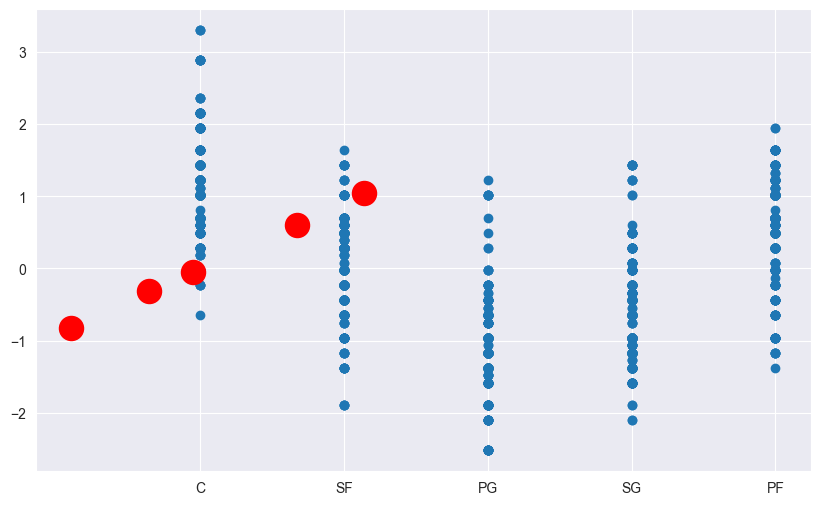

<Figure size 640x480 with 0 Axes>

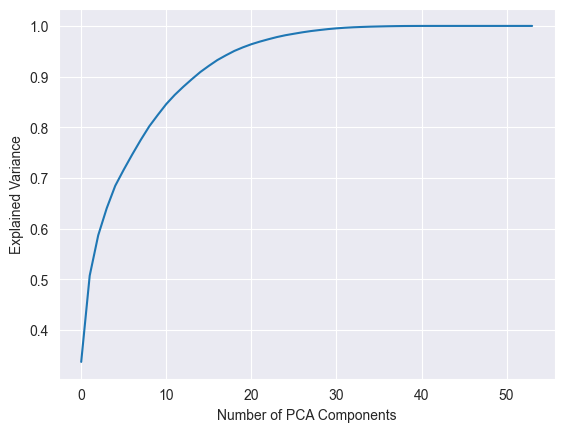

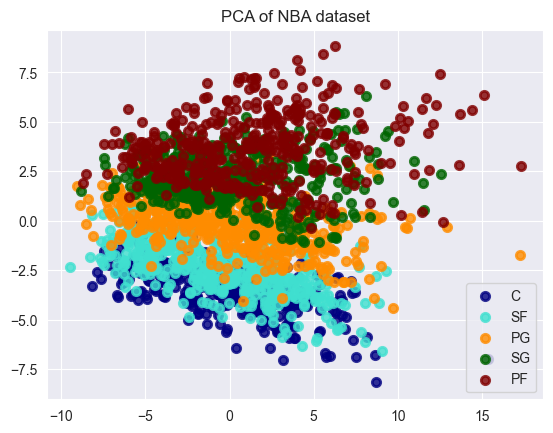

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

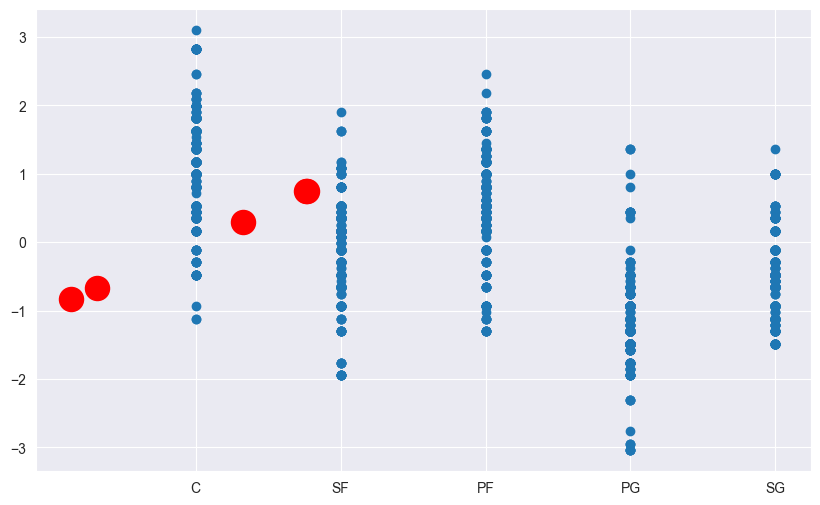

<Figure size 640x480 with 0 Axes>

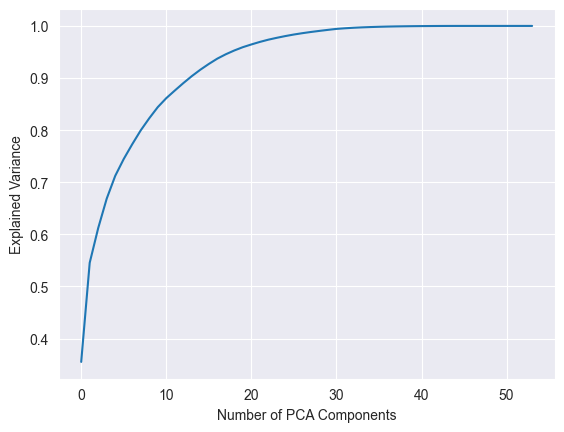

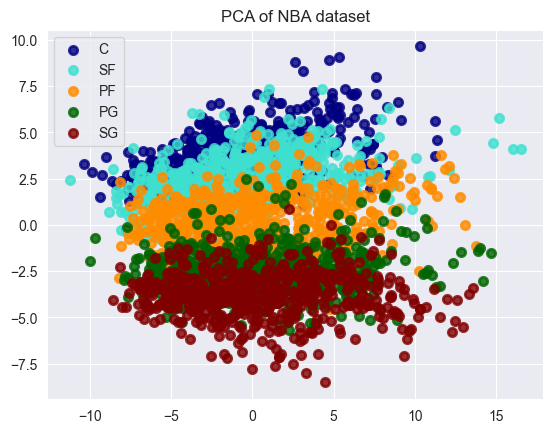

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

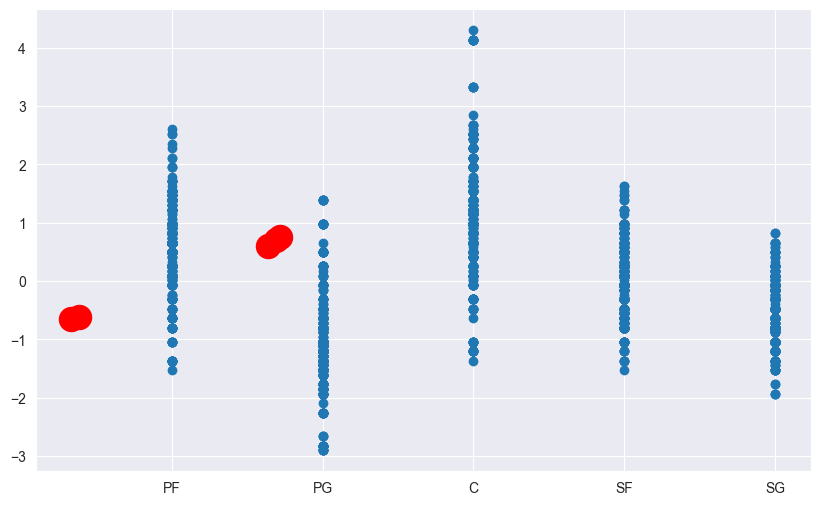

<Figure size 640x480 with 0 Axes>

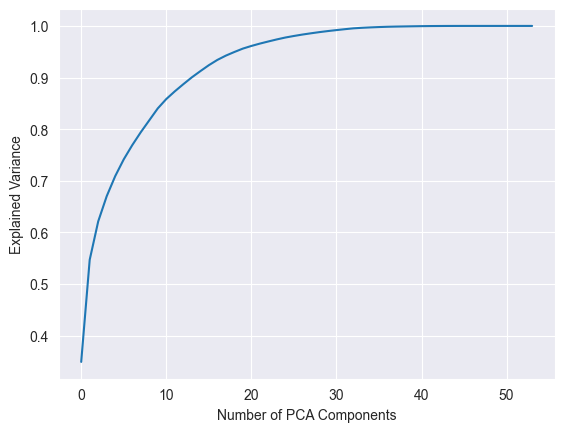

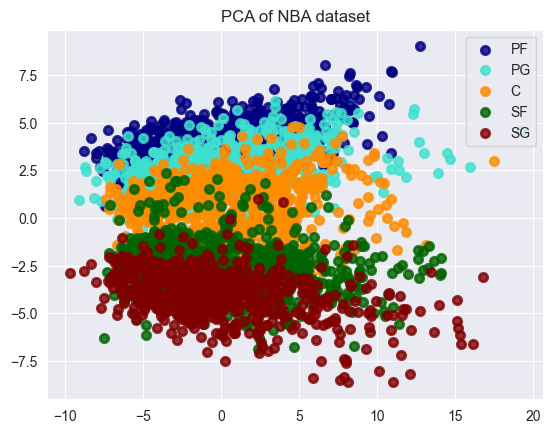

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

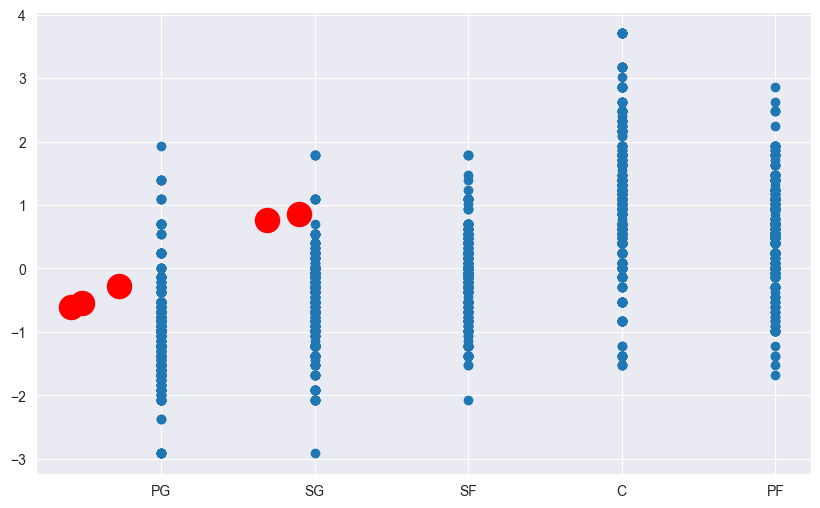

<Figure size 640x480 with 0 Axes>

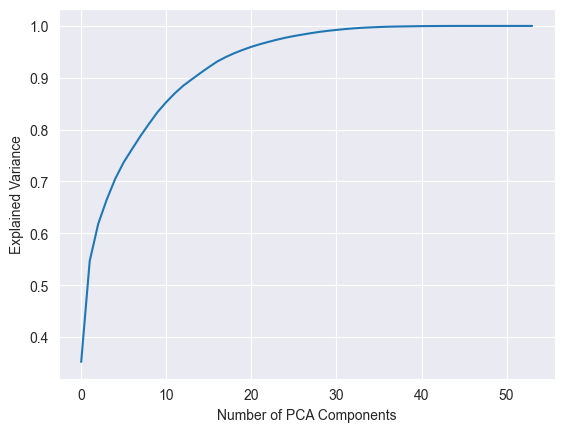

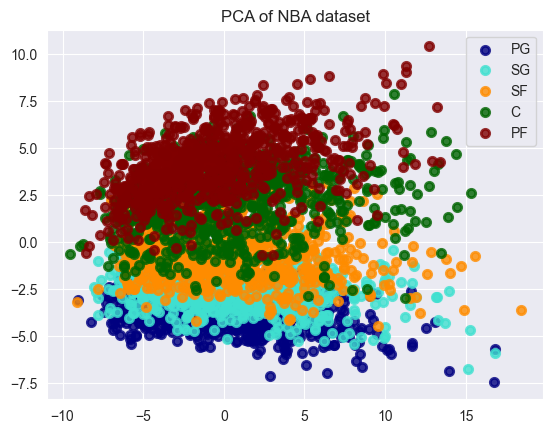

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

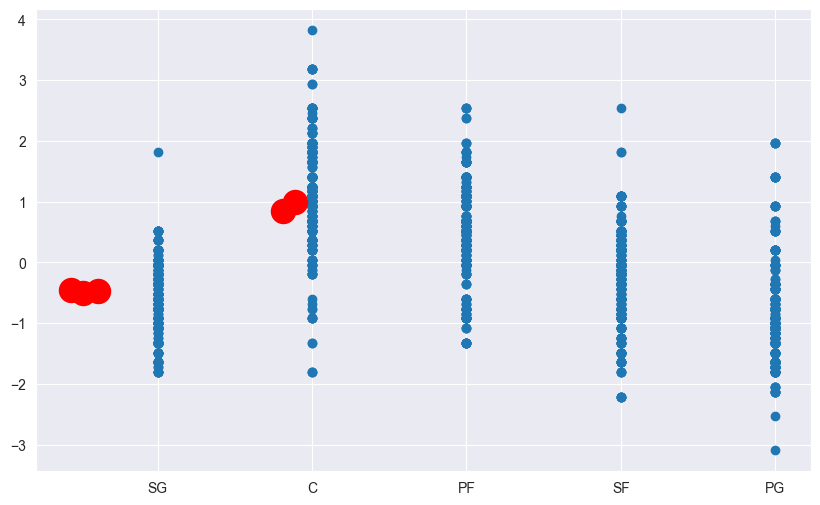

<Figure size 640x480 with 0 Axes>

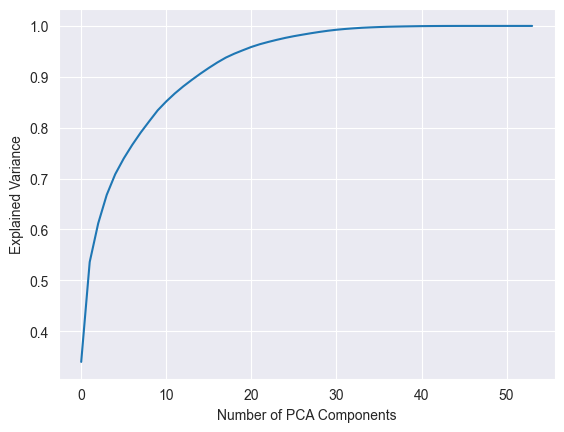

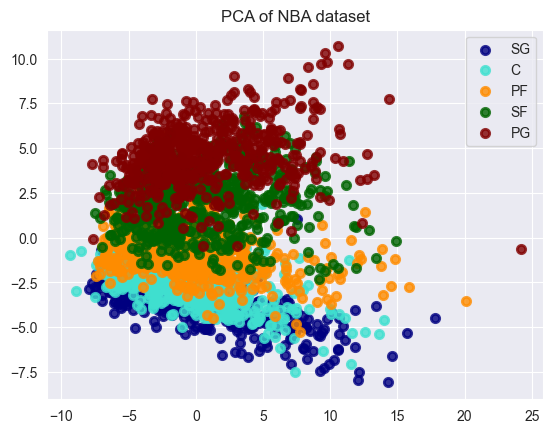

<Figure size 640x480 with 0 Axes>

In [9]:
DEBUG = False
LOAD_MODEL_DATA = True

PLAYER_PATH = "../data/input/Players.csv"
DATA_PATH = "../data/input/Seasons_Stats_1950_2022.csv"  # 1950-2022
OUTPUT_FILES_FLAG = True

HIERARCHICAL = True
SOM = True
KMEANS = True
PCA = True

REQ_GAMES = 20
REQ_MIN = 10
INCLUDE_POS = True
THREE_POSITION_FLAG = False

DQR_NON_NUMERIC_COLUMNS = ['Unnamed: 0', 'Player', 'Tm', 'Pos',
                           'blanl', 'blank2']

YEARS = [[1971, 1980],
         [1981, 1990],
         [1991, 2000],
         [2001, 2010],
         [2011, 2020]]

if DEBUG:
    YEARS = [YEARS[0], YEARS[1]]

##########################
################
##########################

'''
** Program Execution starts HERE **
'''
# Load your own correctly formatted csv file to reduce computation time.
if LOAD_MODEL_DATA:
    df_data = pd.read_csv("../data/ref/Season_Stats_MODEL_{}-{}.csv".format(
        YEARS[0][0], YEARS[len(YEARS) - 1][1]),
        index_col=False)
else:
    df_data = dp.initialDataModification(PLAYER_PATH, DATA_PATH, YEARS,
                                         REQ_GAMES, REQ_MIN,
                                         THREE_POSITION_FLAG,
                                         DQR_NON_NUMERIC_COLUMNS,
                                         OUTPUT_FILES_FLAG)

# Create Cluster Metric dataframe placeholder to collect all metrics.
df_metrics_hierarchy = pd.DataFrame(columns=['Years', 'CHS', 'SC', 'DBI'])
df_metrics_hierarchy_pca = pd.DataFrame(columns=['Years', 'CHS', 'SC', 'DBI'])
df_metrics_som = pd.DataFrame(columns=['Years', 'CHS', 'SC', 'DBI'])
df_metrics_kMeans = pd.DataFrame(columns=['Years', 'CHS', 'SC', 'DBI'])
df_metrics_kMeans_pca = pd.DataFrame(columns=['Years', 'CHS', 'SC', 'DBI'])

# Begin modeling for each set of year-pairs specified.
for YEAR in YEARS:
    df_year = df_data.loc[(df_data['Year'] >= YEAR[0]) &
                          (df_data['Year'] <= YEAR[1])]

    if HIERARCHICAL:
        metrics = hc.hierarchicalClustering(df_year, [YEAR[0], YEAR[1]],
                                            INCLUDE_POS, THREE_POSITION_FLAG)
        df_metrics_hierarchy.loc[len(df_metrics_hierarchy)] = metrics
        print("** Model1 (Divisive Clustering): COMPLETE\n")

        metrics = hc.hierarchicalClustering(df_year, [YEAR[0], YEAR[1]],
                                            INCLUDE_POS, THREE_POSITION_FLAG, True, 5)
        df_metrics_hierarchy_pca.loc[len(df_metrics_hierarchy_pca)] = metrics
        print("** Model1 (Divisive Clustering): COMPLETE\n")

    if SOM:
        metrics = som(df_year, [YEAR[0], YEAR[1]],
                      INCLUDE_POS, THREE_POSITION_FLAG)
        df_metrics_som.loc[len(df_metrics_som)] = metrics
        print("** Model2 (SOM Clustering): COMPLETE\n")

    if KMEANS:
        metrics = kM.runKmeans(df_year, [YEAR[0], YEAR[1]],
                            INCLUDE_POS, THREE_POSITION_FLAG)
        df_metrics_kMeans.loc[len(df_metrics_kMeans)] = metrics
        print("** Model3 (SOM KMeans): COMPLETE\n")

    if PCA:
        metrics = pca.runPCA(df_year, [YEAR[0], YEAR[1]],
                         INCLUDE_POS, THREE_POSITION_FLAG, 0.7)
        df_metrics_kMeans_pca.loc[len(df_metrics_kMeans_pca)] = metrics
        print("** Model4 (PCA): COMPLETE\n")

# Output the resulting cluster metrics to individual .csv files.
display(df_metrics_hierarchy)
df_metrics_hierarchy.to_csv(
    '../data/output/MODEL_Metrics_Hierarchy_{}-{}.csv'.format(
        YEARS[0][0], YEARS[len(YEARS) - 1][1]),
    index=False)

display(df_metrics_hierarchy_pca)
df_metrics_hierarchy_pca.to_csv(
    '../data/output/MODEL_Metrics_Hierarchy_pca_{}-{}.csv'.format(
        YEARS[0][0], YEARS[len(YEARS) - 1][1]),
    index=False)

display(df_metrics_som)
df_metrics_som.to_csv(
    '../data/output/MODEL_Metrics_som_{}-{}.csv'.format(
        YEARS[0][0], YEARS[len(YEARS) - 1][1]),
    index=False)

display(df_metrics_kMeans)
df_metrics_kMeans.to_csv(
    '../data/output/MODEL_Metrics_kMeans_{}-{}.csv'.format(
        YEARS[0][0], YEARS[len(YEARS) - 1][1]),
    index=False)

display(df_metrics_kMeans_pca)
df_metrics_kMeans_pca.to_csv(
    '../data/output/MODEL_Metrics_kMeans_pca_{}-{}.csv'.format(
        YEARS[0][0], YEARS[len(YEARS) - 1][1]),
    index=False)

'''
NOTES for later
1. When outputting metrics for clusters for DEBUG (1971-1990) vs ALL (
1971-2020), the metrics for overlapping years was not consistent.

'''
